# Basic Implementation

In [5]:
import numpy as np

In [3]:
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[512, 512], output_size=10):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights = []
        self.biases = []

        # Input to Hidden Layers Network
        self.weights.append(0.01 * np.random.randn(input_size, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Hidden Layers Network
        for i in range(len(hidden_layers)-1):
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i+1]))
            self.biases.append(np.zeros((1, hidden_layers[i+1])))
        
        # Hidden Layers Network to Output
        self.weights.append(0.01 * np.random.randn(hidden_layers[len(hidden_layers)-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    def forward(self, inputs):
        layers = [inputs]

        for i in range(len(self.weights)):
            # Dot Product to 
            layers.append(np.dot(layers[-1], self.weights[i]) + self.biases[i])

            # Activation Functions (ReLU + SoftMax)
            if i == len(self.weights)-1:
                finalOutput = np.exp(layers[-1] - np.max(layers[-1], axis=1, keepdims=True))
                finalOutput = finalOutput / np.sum(finalOutput, axis=1, keepdims=True)
                layers.append(finalOutput)
            else:
                layers.append(np.maximum(0, layers[-1]))
        
        return layers[-1]


In [1]:
# LossCategoricalCrossEntropy implementation
def LossCategoricalCrossEntropy(yPred, yTrue):
    # If predicted class has a prediction of 0% likelihood this prevents log(0), which would be infinity
    yPred = np.clip(yPred, 1e-10, 1 - 1e-10)

    # We calculate the sum of the log losses
    loss = -np.sum(yTrue * np.log(yPred), axis=1)

    # We calculate the average loss - this depends on the number of samples
    # So the return loss is the average loss not the summed up loss (which took me a while to understand)
    average_loss = np.mean(loss)

    return average_loss


In [6]:
myNeuralNet = NeuralNetwork()

In [7]:
result = myNeuralNet.forward(np.random.rand(1, 784))
result

array([[0.10005443, 0.09957102, 0.10021873, 0.09973396, 0.09948324,
        0.10095883, 0.09995889, 0.09989615, 0.09975392, 0.10037081]])

# Get Weights from PyTorch Model

In [8]:
modelMNIST = NeuralNetwork(hidden_layers=[256])

In [9]:
# Import Weights from Folder
modelWeights = []
modelWeights.append(np.load("./modelWeights/layer_stack.1.weight.npy"))
modelWeights.append(np.load("./modelWeights/layer_stack.3.weight.npy"))
modelBiases = []
modelBiases.append(np.load("./modelWeights/layer_stack.1.bias.npy"))
modelBiases.append(np.load("./modelWeights/layer_stack.3.bias.npy"))

In [10]:
# Visualize Biases:
for i in range(len(modelBiases)):
    print(f"Shapes PytTorchModel: {modelBiases[i].shape}")
    print(f"Shapes PytTorchModel Transformed: {np.expand_dims(modelBiases[i], axis=0).shape}")
    print(f"Shapes MyModel: {modelMNIST.biases[i].shape}")
    print()

# Visualize Weights:
for i in range(len(modelWeights)):
    print(f"Shapes PytTorchModel: {modelWeights[i].shape}")
    print(f"Shapes PytTorchModel Transformed: {modelWeights[i].T.shape}")
    print(f"Shapes MyModel: {modelMNIST.weights[i].shape}")
    print()

Shapes PytTorchModel: (256,)
Shapes PytTorchModel Transformed: (1, 256)
Shapes MyModel: (1, 256)

Shapes PytTorchModel: (10,)
Shapes PytTorchModel Transformed: (1, 10)
Shapes MyModel: (1, 10)

Shapes PytTorchModel: (256, 784)
Shapes PytTorchModel Transformed: (784, 256)
Shapes MyModel: (784, 256)

Shapes PytTorchModel: (10, 256)
Shapes PytTorchModel Transformed: (256, 10)
Shapes MyModel: (256, 10)



In [11]:
# Change Biases:
for i in range(len(modelBiases)):
    modelMNIST.biases[i] = np.expand_dims(modelBiases[i], axis=0)

# Change Weights:
for i in range(len(modelWeights)):
    modelMNIST.weights[i] = modelWeights[i].T

In [12]:
import gzip

# Load MNIST dataset
def extract_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32, count=4).byteswap()
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def extract_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num = np.frombuffer(f.read(8), dtype=np.uint32, count=2).byteswap()
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = extract_images("./MNISTdata/train-images-idx3-ubyte.gz")
train_labels = extract_labels("./MNISTdata/train-labels-idx1-ubyte.gz")
test_images = extract_images("./MNISTdata/t10k-images-idx3-ubyte.gz")
test_labels = extract_labels("./MNISTdata/t10k-labels-idx1-ubyte.gz")

In [13]:
testImage1 = np.expand_dims(test_images[0].flatten(), axis=0)
print(f"Test Label: {test_labels[0]}")
print(f"Predicted Label: {modelMNIST.forward(testImage1)}")

Test Label: 7
Predicted Label: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [14]:
correct = 0
incorrect = 0
for i in range(len(test_images)):
    image = np.expand_dims(test_images[i].flatten(), axis=0)

    if int(test_labels[i]) == int(modelMNIST.forward(image).argmax()):
        correct += 1
    else:
        incorrect += 1

(correct)/(correct+incorrect)

0.9392

# Implement Backpropagation

In [15]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[512, 512], output_size=10):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights = []
        self.biases = []
        self.gradientsWeights = []
        self.gradientsBiases = []
        self.iterations = 0

        # Input to Hidden Layers Network
        # np.random.seed(0)
        self.weights.append(0.01 * np.random.randn(input_size, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Hidden Layers Network
        for i in range(len(hidden_layers)-1):
            # np.random.seed(0)
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i+1]))
            self.biases.append(np.zeros((1, hidden_layers[i+1])))
        
        # Hidden Layers Network to Output
        # np.random.seed(0)
        self.weights.append(0.01 * np.random.randn(hidden_layers[len(hidden_layers)-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    def forward(self, inputs):
        self.outputs = [inputs]
        self.outputsTesting = ["inputs"]

        for i in range(len(self.weights)):
            # Dot Product to 
            self.outputs.append(np.dot(self.outputs[-1], self.weights[i]) + self.biases[i])
            self.outputsTesting.append("dense")

            # Activation Functions (ReLU + SoftMax)
            if i == len(self.weights)-1:
                finalOutput = np.exp(self.outputs[-1] - np.max(self.outputs[-1], axis=1, keepdims=True))
                finalOutput = finalOutput / np.sum(finalOutput, axis=1, keepdims=True)
                self.outputs.append(finalOutput)
                self.outputsTesting.append("softmax")
            else:
                self.outputs.append(np.maximum(0, self.outputs[-1]))
                self.outputsTesting.append("relu")
        
        return self.outputs[-1]
    
    def backwards(self, y_true):
        # Softmax + LossCategoricalEntropy 
        #       -> Still don't fully understand the derivation for this (working on it)
        #       -> I roughly understand the following code but it was extracted from the nnfs textbook
        #       -> nnfs textBook -> https://nnfs.io/

        # Number of samples
        samples = len(self.outputs[-1])

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            print("Chaning to Discrete Values")
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        dSoftMaxCrossEntropy = self.outputs[-1].copy()
        # Calculate gradient
        dSoftMaxCrossEntropy[range(samples), y_true] -= 1
        # Normalize gradient
        dSoftMaxCrossEntropy = dSoftMaxCrossEntropy / samples
        # print(dSoftMaxCrossEntropy)

        # print(dSoftMaxCrossEntropy)
        # Calculate gradients -> Calcualte derivative of weights, biases, and inputs (to continue to backpropagate)
        dInputs = np.dot(dSoftMaxCrossEntropy.copy(), self.weights[-1].T)

        dWeights = np.dot(self.outputs[-3].T, dSoftMaxCrossEntropy.copy())
        dBiases = np.sum(dSoftMaxCrossEntropy.copy(), axis=0, keepdims=True)
        self.gradientsWeights = [dWeights] + self.gradientsWeights
        self.gradientsBiases = [dBiases] + self.gradientsBiases


        i = -3
        j = -1
        for _ in range(len(self.hidden_layers)):
            i -= 1
            j -= 1
            
            # ReLU activation Function
            dInputsReLU = dInputs.copy()
            dInputsReLU[self.outputs[i] <= 0] = 0
            
            i -= 1
            dInputs = np.dot(dInputsReLU, self.weights[j].T)
            dWeights = np.dot(self.outputs[i].T, dInputsReLU)
            dBiases = np.sum(dInputsReLU, axis=0, keepdims=True)
            self.gradientsWeights = [dWeights] + self.gradientsWeights
            self.gradientsBiases = [dBiases] + self.gradientsBiases

        # print("dense1.dweights")
        # print(dWeights)
        # print(dWeights.shape)
        # print("dense1.dbiases")
        # print(dBiases)
        # print(dBiases.shape)
    
    def updateParams(self, lr=0.05, decay=1e-7):
        lr = lr * (1. / (1. + decay * self.iterations))

        for i in range(len(self.weights)-1):
            if i != len(self.weights)-1:
                assert self.weights[i].shape == self.gradientsWeights[i].shape
                self.weights[i] += -lr*self.gradientsWeights[i]
        
        for i in range(len(self.biases)-1):
            if i != len(self.biases)-1:
                assert self.biases[i].shape == self.gradientsBiases[i].shape
                self.biases[i] += -lr*self.gradientsBiases[i]
        
        # print(f"Learning Rate: {lr}")
        
        self.iterations += 1

# LossCategoricalCrossEntropy implementation
def LossCategoricalCrossEntropy(yPred, yTrue):
    # If predicted class has a prediction of 0% likelihood this prevents log(0), which would be infinity
    yPred = np.clip(yPred, 1e-10, 1 - 1e-10)

    # We calculate the sum of the log losses
    loss = -np.sum(yTrue * np.log(yPred), axis=1)

    # We calculate the average loss - this depends on the number of samples
    # So the return loss is the average loss not the summed up loss (which took me a while to understand)
    average_loss = np.mean(loss)

    return average_loss

def sparse_to_one_hot(sparse_labels, num_classes):
    one_hot_encoded = np.zeros((len(sparse_labels), num_classes))
    one_hot_encoded[np.arange(len(sparse_labels)), sparse_labels] = 1
    return one_hot_encoded


In [16]:
myNeuralNet = NeuralNetwork(hidden_layers=[128, 128])

In [17]:
train_images = extract_images("./MNISTdata/train-images-idx3-ubyte.gz")
train_labels = extract_labels("./MNISTdata/train-labels-idx1-ubyte.gz")
test_images = extract_images("./MNISTdata/t10k-images-idx3-ubyte.gz")
test_labels = extract_labels("./MNISTdata/t10k-labels-idx1-ubyte.gz")

# MNIST TRAINING

In [18]:
data = train_images
dataLabels = train_labels

# Normalize
data = (data.astype(np.float32)-127.5)/127.5

data = data.reshape(60000, 784)

accuracies = []
losses = []

BATCH_SIZE = 32

# Main training loop
for epoch in range(1, 3):
    print(f'epoch: {epoch}')
    train_steps = len(data) // BATCH_SIZE

    for step in range(train_steps):
        batch_X = data[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        batch_y = dataLabels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]

        X = batch_X
        y = batch_y

        output = myNeuralNet.forward(X)

        if step % 100 == 0:
            predictions = np.argmax(output, axis=1)
            if len(y.shape) == 2:
                y = np.argmax(y, axis=1)
            accuracy = np.mean(predictions==y)

            loss = LossCategoricalCrossEntropy(output, sparse_to_one_hot(y, 10))
            accuracies.append(accuracy)
            losses.append(loss)

            print(f'epoch: {epoch}, ' +
                    f'acc: {accuracy:.3f}, ' +
                    f'loss: {loss:.3f}')
        
        # Backward pass
        myNeuralNet.backwards(y)

        # Update weights and biases
        myNeuralNet.updateParams(lr=0.5, decay=1e-6)

epoch: 1
epoch: 1, acc: 0.156, loss: 2.302
epoch: 1, acc: 0.531, loss: 1.726
epoch: 1, acc: 0.719, loss: 0.736
epoch: 1, acc: 0.719, loss: 0.752
epoch: 1, acc: 0.938, loss: 0.380
epoch: 1, acc: 0.906, loss: 0.561
epoch: 1, acc: 0.906, loss: 0.276
epoch: 1, acc: 0.969, loss: 0.205
epoch: 1, acc: 0.844, loss: 0.255
epoch: 1, acc: 0.906, loss: 0.194
epoch: 1, acc: 0.875, loss: 0.368
epoch: 1, acc: 0.875, loss: 0.416
epoch: 1, acc: 0.938, loss: 0.239
epoch: 1, acc: 0.844, loss: 0.420
epoch: 1, acc: 0.875, loss: 0.282
epoch: 1, acc: 0.938, loss: 0.216
epoch: 1, acc: 0.875, loss: 0.344
epoch: 1, acc: 0.875, loss: 0.225
epoch: 1, acc: 0.938, loss: 0.246
epoch: 2
epoch: 2, acc: 0.906, loss: 0.204
epoch: 2, acc: 0.875, loss: 0.327
epoch: 2, acc: 0.938, loss: 0.222
epoch: 2, acc: 1.000, loss: 0.065
epoch: 2, acc: 0.969, loss: 0.152
epoch: 2, acc: 0.875, loss: 0.262
epoch: 2, acc: 0.875, loss: 0.205
epoch: 2, acc: 0.969, loss: 0.104
epoch: 2, acc: 0.938, loss: 0.121
epoch: 2, acc: 0.969, loss: 0.

In [19]:
dataTest = test_images
dataTestLabels = test_labels

# Normalize
dataTest = (dataTest.astype(np.float32)-127.5)/127.5
print(dataTest.shape)
dataTest = dataTest.reshape(10000, 784)

X = dataTest
y = dataTestLabels

output = myNeuralNet.forward(dataTest)

predictions = np.argmax(output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)
print(accuracy)

(10000, 28, 28)
0.9458


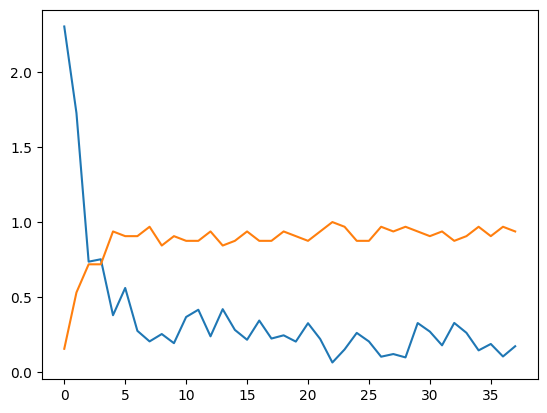

In [20]:
import matplotlib.pyplot as mp

mp.plot(losses)
mp.plot(accuracies)

### Testing

Probabilities: [[6.72233603e-06 2.06703406e-05 4.82291448e-05 7.99822579e-05
  2.08640683e-03 5.65365958e-03 5.14821221e-05 3.41608432e-07
  9.91541197e-01 5.11308665e-04]]
Prediction: [8]


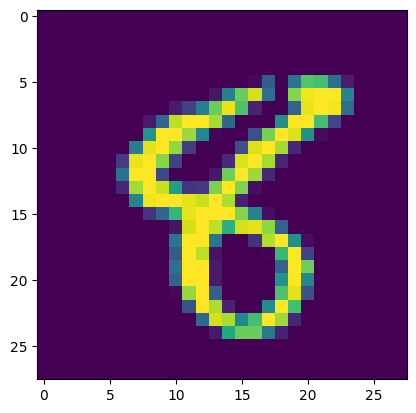

In [23]:
import matplotlib.pyplot as mp
dataTest = test_images
dataTestLabels = test_labels

# Normalize
dataTest = (dataTest.astype(np.float32)-127.5)/127.5
dataTest = dataTest.reshape(10000, 784)

X = dataTest[84]
y = dataTestLabels[84]

output = myNeuralNet.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[1.89282478e-05 3.09118759e-07 6.89774587e-04 1.23065375e-04
  1.66297295e-02 9.21654062e-05 1.54462818e-05 5.55489616e-03
  1.00095351e-03 9.75874732e-01]]
Prediction: [9]


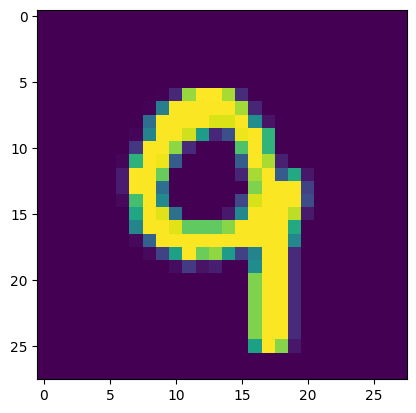

In [20]:
X = dataTest[678]
y = dataTestLabels[678]

output = myNeuralNet.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[2.60296771e-04 3.43802612e-06 1.09459891e-05 4.91435851e-03
  5.20278722e-07 9.89967740e-01 1.67140827e-06 2.18113438e-07
  4.73429316e-03 1.06518179e-04]]
Prediction: [5]


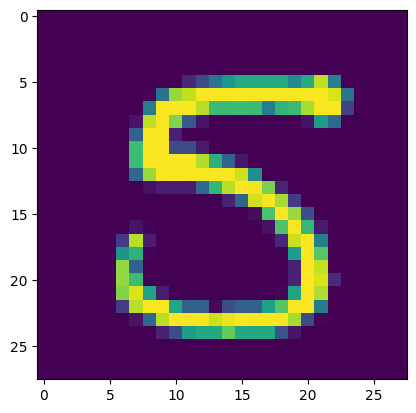

In [21]:
X = dataTest[2948]
y = dataTestLabels[2948]

output = myNeuralNet.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[1.26853482e-01 1.59458412e-07 8.59649456e-04 1.58911193e-04
  1.12798598e-03 9.27510050e-03 8.57414644e-06 1.47115275e-01
  9.17331348e-04 7.13683531e-01]]
Prediction: [9]


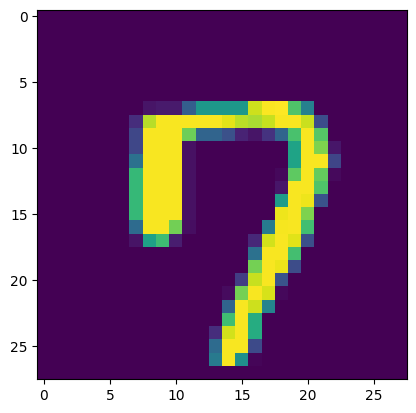

In [22]:
X = dataTest[1096]
y = dataTestLabels[1096]

output = myNeuralNet.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[2.83653272e-03 2.24805255e-06 1.51147205e-02 3.92532338e-05
  1.77981975e-02 1.46860693e-02 9.40766083e-01 2.81519415e-06
  7.85131784e-03 9.02762283e-04]]
Prediction: [6]


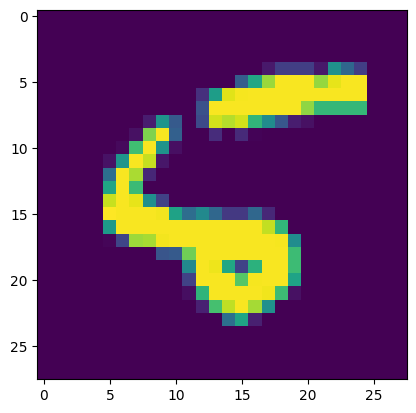

In [23]:
import matplotlib.pyplot as plt
for i in range(len(dataTest)):
    X = dataTest[i]
    y = dataTestLabels[i]

    output = myNeuralNet.forward(X)
    prediction = np.argmax(output, axis=1)
    if prediction[0] != y:
        print(f"Probabilities: {output}")
        print(f"Prediction: {prediction}")

        mp.imshow(X.reshape(28, 28))
        break

Probabilities: [[9.39246322e-05 6.48123238e-04 1.09549074e-04 8.56482577e-03
  3.85084611e-05 2.69276059e-03 4.47820228e-05 7.94943588e-07
  9.87530772e-01 2.75959191e-04]]
Prediction: [8]


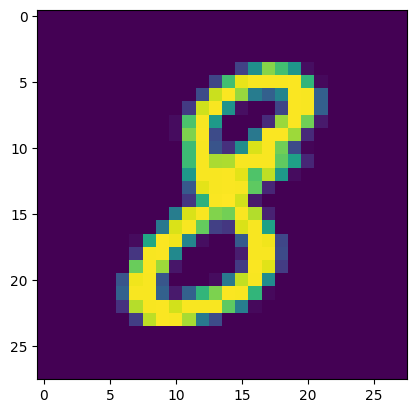

In [25]:
import matplotlib.pyplot as plt

split = dataTest[100:]
splitLabels = dataTestLabels[100:]
for i in range(len(dataTest)):
    X = split[i]
    y = splitLabels[i]

    output = myNeuralNet.forward(X)
    prediction = np.argmax(output, axis=1)
    if y == 8:
        if prediction[0] == y:
            print(f"Probabilities: {output}")
            print(f"Prediction: {prediction}")

            mp.imshow(X.reshape(28, 28))
            break

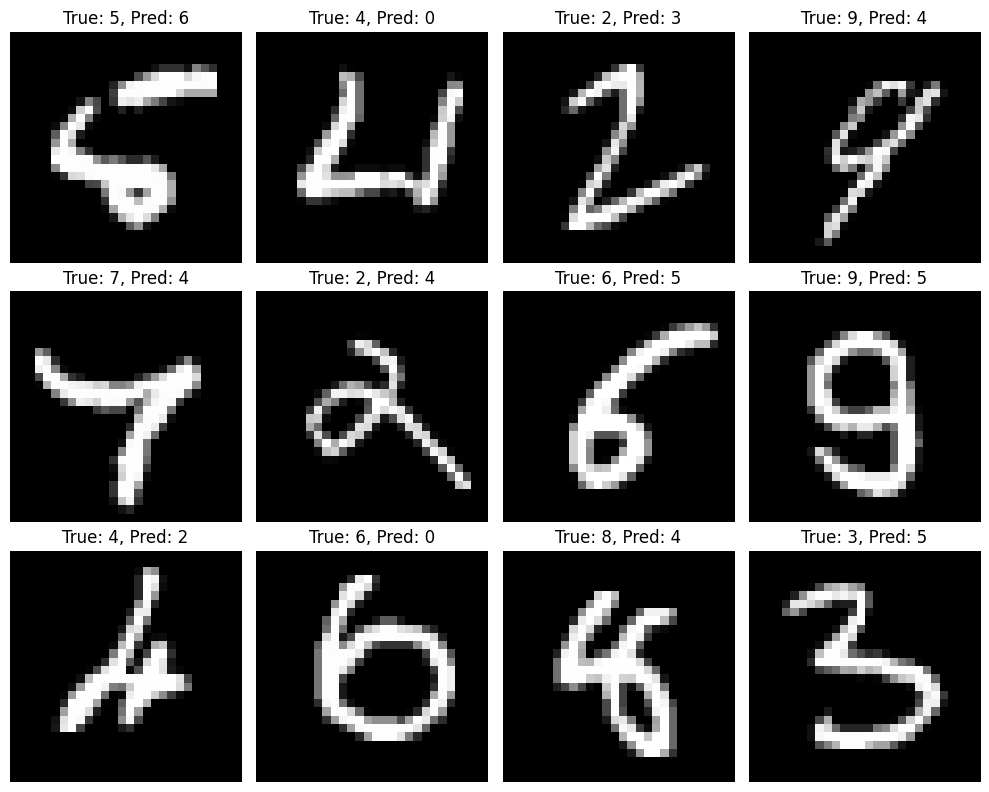

In [26]:
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []

for i in range(len(dataTest)):
    X = dataTest[i]
    y = dataTestLabels[i]

    output = myNeuralNet.forward(X)
    prediction = np.argmax(output, axis=1)
    if prediction[0] != y:
        incorrect_images.append(X)
        incorrect_labels.append(y)
        incorrect_predictions.append(prediction[0])
        
        if len(incorrect_images) == 12:
            break

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes = axes.ravel()

for i in range(12):
    axes[i].imshow(incorrect_images[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {incorrect_labels[i]}, Pred: {incorrect_predictions[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Testing Own Images

Probabilities: [[1.72608044e-05 2.99158518e-05 1.45028183e-02 5.44665390e-03
  5.24632333e-07 9.74875468e-01 3.53298656e-04 8.42822044e-10
  4.77395929e-03 9.98493741e-08]]
Prediction: [5]


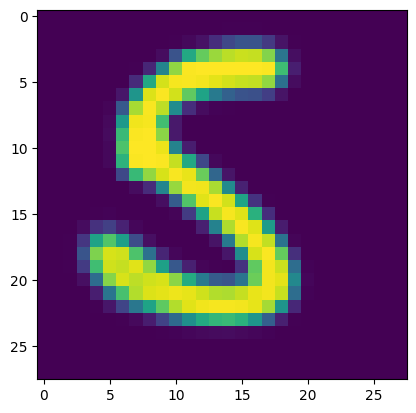

In [30]:
from PIL import Image
import numpy as np

image_path = './testImages/Number5.png'  # replace with your image path
image = Image.open(image_path)

gray_image = image.convert('L')

# Step 4: Convert the image to a NumPy array
image_array = np.array(gray_image)
image_array = (image_array.astype(np.float32)-127.5)/127.5
image_array = image_array.reshape(1, 784)


output = myNeuralNet.forward(image_array)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Prediction: {prediction}")

mp.imshow(image_array.reshape(28, 28))


## Fashion MNIST

In [31]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [28]:
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -P ./fashionMNIST/
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -P ./fashionMNIST/
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -P ./fashionMNIST/
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -P ./fashionMNIST/

In [32]:
X_train, y_train = load_mnist('fashionMNIST', kind='train')
X_test, y_test = load_mnist('fashionMNIST', kind='t10k')

modelFashionMNIST = NeuralNetwork(hidden_layers=[256, 256])

In [33]:
data = X_train
dataLabels = y_train

# Normalize
data = (data.astype(np.float32)-127.5)/127.5

data = data.reshape(60000, 784)

accuracies = []
losses = []

BATCH_SIZE = 32

# Main training loop
for epoch in range(1, 3):
    print(f'epoch: {epoch}')
    train_steps = len(data) // BATCH_SIZE

    for step in range(train_steps):
        batch_X = data[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        batch_y = dataLabels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]

        X = batch_X
        y = batch_y

        output = modelFashionMNIST.forward(X)

        if step % 100 == 0:
            predictions = np.argmax(output, axis=1)
            if len(y.shape) == 2:
                y = np.argmax(y, axis=1)
            accuracy = np.mean(predictions==y)

            loss = LossCategoricalCrossEntropy(output, sparse_to_one_hot(y, 10))
            accuracies.append(accuracy)
            losses.append(loss)

            print(f'epoch: {epoch}, ' +
                    f'acc: {accuracy:.3f}, ' +
                    f'loss: {loss:.3f}')
        
        # Backward pass
        modelFashionMNIST.backwards(y)

        # Update weights and biases
        modelFashionMNIST.updateParams(lr=0.8, decay=1e-6)

epoch: 1
epoch: 1, acc: 0.031, loss: 2.302
epoch: 1, acc: 0.562, loss: 1.092
epoch: 1, acc: 0.781, loss: 0.500
epoch: 1, acc: 0.781, loss: 0.716
epoch: 1, acc: 0.844, loss: 0.465
epoch: 1, acc: 0.656, loss: 0.970
epoch: 1, acc: 0.875, loss: 0.457
epoch: 1, acc: 0.875, loss: 0.298
epoch: 1, acc: 0.812, loss: 0.470
epoch: 1, acc: 0.875, loss: 0.473
epoch: 1, acc: 0.750, loss: 0.556
epoch: 1, acc: 0.812, loss: 0.475
epoch: 1, acc: 0.844, loss: 0.465
epoch: 1, acc: 0.750, loss: 0.731
epoch: 1, acc: 0.781, loss: 0.610
epoch: 1, acc: 0.844, loss: 0.394
epoch: 1, acc: 0.812, loss: 0.530
epoch: 1, acc: 0.812, loss: 0.459
epoch: 1, acc: 0.750, loss: 0.512
epoch: 2
epoch: 2, acc: 0.875, loss: 0.307
epoch: 2, acc: 0.812, loss: 0.358
epoch: 2, acc: 0.969, loss: 0.230
epoch: 2, acc: 0.812, loss: 0.535
epoch: 2, acc: 0.906, loss: 0.308
epoch: 2, acc: 0.844, loss: 0.790
epoch: 2, acc: 0.875, loss: 0.311
epoch: 2, acc: 0.938, loss: 0.233
epoch: 2, acc: 0.875, loss: 0.336
epoch: 2, acc: 0.875, loss: 0.

In [34]:
dataTest = X_test
dataTestLabels = y_test

# Normalize
dataTest = (dataTest.astype(np.float32)-127.5)/127.5
print(dataTest.shape)
dataTest = dataTest.reshape(10000, 784)

X = dataTest
y = dataTestLabels

output = modelFashionMNIST.forward(dataTest)

predictions = np.argmax(output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)
print(accuracy)

(10000, 784)
0.8589


### Testing

Probabilities: [[8.06463689e-07 2.30473905e-09 7.86626179e-08 2.06700302e-08
  2.13021525e-07 1.93473061e-05 3.65895679e-08 1.19889792e-06
  9.99978158e-01 1.37640107e-07]]
Label: 8
Prediction: [8]


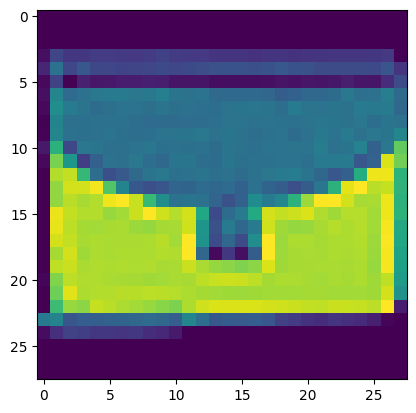

In [ ]:
import matplotlib.pyplot as mp
dataTest = X_test
dataTestLabels = y_test

# Normalize
dataTest = (dataTest.astype(np.float32)-127.5)/127.5
dataTest = dataTest.reshape(10000, 784)

X = dataTest[78]
y = dataTestLabels[78]

output = modelFashionMNIST.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Label: {y}")
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[5.69649727e-06 9.99960434e-01 2.05495824e-07 3.26783056e-05
  2.89381355e-07 7.11013733e-09 6.42671936e-07 6.11688683e-09
  3.87351737e-08 1.28297907e-09]]
Label: 1
Prediction: [1]


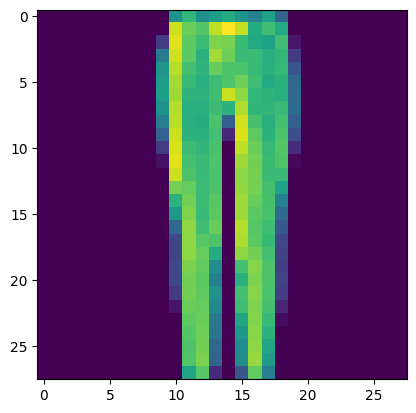

In [ ]:
X = dataTest[345]
y = dataTestLabels[345]

output = modelFashionMNIST.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Label: {y}")
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[1.15353789e-02 3.40824799e-05 8.60011110e-01 2.43933523e-04
  8.19118557e-03 1.62324866e-04 1.17590108e-01 1.43684751e-06
  2.21838780e-03 1.20518320e-05]]
Label: 2
Prediction: [2]


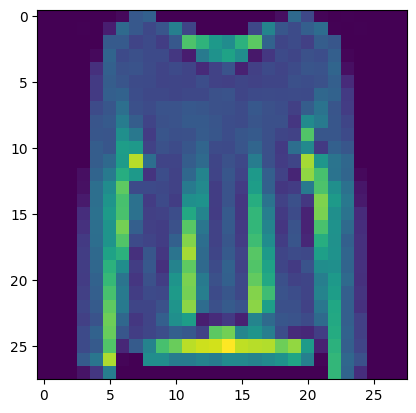

In [ ]:
X = dataTest[3456]
y = dataTestLabels[3456]

output = modelFashionMNIST.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Label: {y}")
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

Probabilities: [[6.14639721e-05 9.78623028e-10 1.58692404e-05 4.28524067e-07
  1.35143346e-05 2.68094030e-06 2.16230829e-08 6.16461702e-10
  9.99906019e-01 3.44708731e-10]]
Label: 8
Prediction: [8]


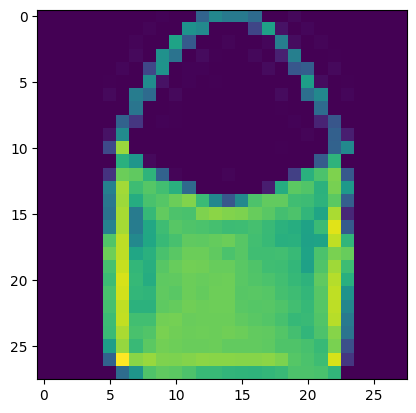

In [ ]:
X = dataTest[34]
y = dataTestLabels[34]

output = modelFashionMNIST.forward(X)
print(f"Probabilities: {output}")

prediction = np.argmax(output, axis=1)
print(f"Label: {y}")
print(f"Prediction: {prediction}")

mp.imshow(X.reshape(28, 28))

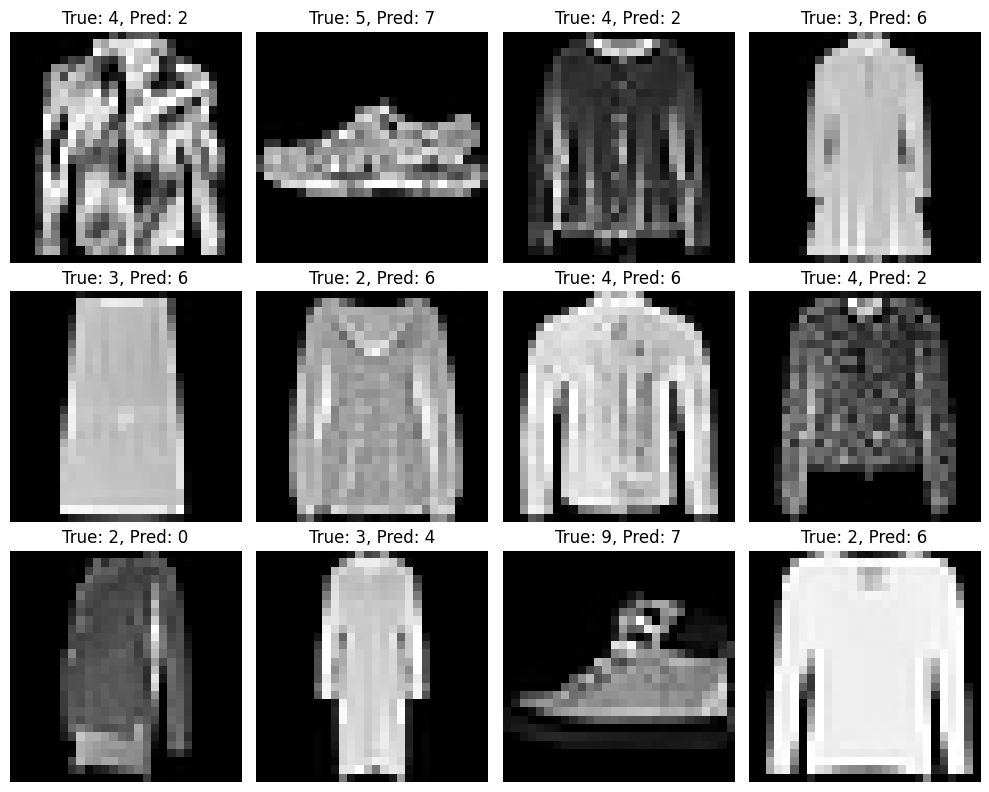

In [ ]:
import matplotlib.pyplot as plt
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []

for i in range(len(dataTest)):
    X = dataTest[i]
    y = dataTestLabels[i]

    output = modelFashionMNIST.forward(X)
    prediction = np.argmax(output, axis=1)
    if prediction[0] != y:
        incorrect_images.append(X)
        incorrect_labels.append(y)
        incorrect_predictions.append(prediction[0])
        
        if len(incorrect_images) == 12:
            break

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes = axes.ravel()

for i in range(12):
    axes[i].imshow(incorrect_images[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'True: {incorrect_labels[i]}, Pred: {incorrect_predictions[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Notes

(batchNumber[32], inputs[718]) * (weights[718], weights[512]) = (32, 512)

- Implement GitHub Repo - DONE

Forward pass - Train 
    - Neurons + - DONE
    - Acitvation function + - DONE
    - Softwax (get probablities) + - DONE
    - loss - DONE
    - Test Forward Pass with Other Model Gradients - DONE

Implement backpropagation
    - Explain how to do and everything
    - Start training with basic 80-20

Introduce regularization
Batch Normalization

Optimizer

Visualize gradients

Visualize MNIST with UMAP or T-SNE